# 📊 Subscriber Pipeline Exploration Notebook
#### This notebook explores the raw and cleaned data used in the Subscriber Pipeline project.
All paths are project-relative so this notebook can be run by anyone who clones the repository, regardless of where Jupyter is launched from.

In [23]:
#Important imports
import sqlite3
import pandas as pd
import numpy as np
import os
import ast

from pathlib import Path

In [24]:
# Function to walk up the tree to find project root
def find_project_root(start_dir, marker_folders):
    """
    Walk up from start_dir until a folder containing all marker_folders is found.
    Returns the resolved root path, or None if not found.
    """
    current = Path(start_dir).resolve()
    while True:
        # Check if this level contains marker subpaths
        if all((current / m).exists() for m in marker_folders):
            return current
        if current.parent == current:
            break
        current = current.parent
    return None

# Attempt 1: start at notebook working directory
cwd = Path(os.getcwd()).resolve()
# Attempt 2: if notebook is in a different location, also check that directly
nb_dir = Path(os.path.abspath("")).resolve()

# Define what identifies your project root
# We know your project root should contain data/raw/cademycode.db
markers = [Path("data") / "raw", ]  # We only need the data/raw folder to exist

root = find_project_root(cwd, markers)
if root is None:
    root = find_project_root(nb_dir, markers)

if root is None:
    raise FileNotFoundError(
        "Could not detect the project root. Make sure this notebook "
        "is inside your subscriber-pipeline folder."
    )

PROJECT_ROOT = root
print("Detected PROJECT_ROOT:", PROJECT_ROOT)

# Define relative paths
RAW_DB_PATH = PROJECT_ROOT / "data" / "raw" / "cademycode.db"
PROD_DIR = PROJECT_ROOT / "prod"
CLEANSED_DB_PATH = PROD_DIR / "cademycode_cleansed.db"
CLEANSED_CSV_PATH = PROD_DIR / "cademycode_cleansed.csv"

print("RAW_DB_PATH:", RAW_DB_PATH)
print("CLEANSED_DB_PATH:", CLEANSED_DB_PATH)
print("CLEANSED_CSV_PATH:", CLEANSED_CSV_PATH)

# Ensure the raw database exists
if not RAW_DB_PATH.exists():
    raise FileNotFoundError(f"Could not find the database at:\n{RAW_DB_PATH}")

Detected PROJECT_ROOT: C:\Users\Shivay Ramrathy\Desktop\subscriber-pipeline
RAW_DB_PATH: C:\Users\Shivay Ramrathy\Desktop\subscriber-pipeline\data\raw\cademycode.db
CLEANSED_DB_PATH: C:\Users\Shivay Ramrathy\Desktop\subscriber-pipeline\prod\cademycode_cleansed.db
CLEANSED_CSV_PATH: C:\Users\Shivay Ramrathy\Desktop\subscriber-pipeline\prod\cademycode_cleansed.csv


In [25]:
# Try connecting to db
try:
    con = sqlite3.connect(str(RAW_DB_PATH))
    print("Connected to raw database successfully!")
    cur = con.cursor()
except Exception as e:
    print("Error connecting:", e)
    raise

Connected to raw database successfully!


# __Analyse and Clean Tables__

In [26]:
#view table schema
tables = [t for t in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
print(tables)

[('cademycode_students',), ('cademycode_courses',), ('cademycode_student_jobs',)]


In [27]:
#read all tables and save to the env
students = pd.read_sql_query("SELECT * FROM cademycode_students", con)
career_paths = pd.read_sql_query("SELECT * FROM cademycode_courses", con)
student_jobs = pd.read_sql_query("SELECT * FROM cademycode_student_jobs", con)

print('students: ', len(students))
print('career paths: ', len(career_paths))
print('student_jobs: ', len(student_jobs))

students:  5000
career paths:  10
student_jobs:  13


## __Students Table__

In [28]:
#view first 5 rows and table structure
students.head()

,uuid,name,dob,sex,contact_info,job_id,num_course_taken,current_career_path_id,time_spent_hrs
0,1,Annabelle Avery,1943-07-03,F,"{""mailing_address"": ""303 N Timber Key, Irondal...",7.0,6.0,1.0,4.99
1,2,Micah Rubio,1991-02-07,M,"{""mailing_address"": ""767 Crescent Fair, Shoals...",7.0,5.0,8.0,4.4
2,3,Hosea Dale,1989-12-07,M,"{""mailing_address"": ""P.O. Box 41269, St. Bonav...",7.0,8.0,8.0,6.74
3,4,Mariann Kirk,1988-07-31,F,"{""mailing_address"": ""517 SE Wintergreen Isle, ...",6.0,7.0,9.0,12.31
4,5,Lucio Alexander,1963-08-31,M,"{""mailing_address"": ""18 Cinder Cliff, Doyles b...",7.0,14.0,3.0,5.64


In [29]:
#view data types and null values
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    5000 non-null   int64 
 1   name                    5000 non-null   object
 2   dob                     5000 non-null   object
 3   sex                     5000 non-null   object
 4   contact_info            5000 non-null   object
 5   job_id                  4995 non-null   object
 6   num_course_taken        4749 non-null   object
 7   current_career_path_id  4529 non-null   object
 8   time_spent_hrs          4529 non-null   object
dtypes: int64(1), object(8)
memory usage: 351.7+ KB


In [30]:
students[students.isnull().any(axis=1)]

,uuid,name,dob,sex,contact_info,job_id,num_course_taken,current_career_path_id,time_spent_hrs
15,16,Norene Dalton,1976-04-30,F,"{""mailing_address"": ""130 Wishing Essex, Branch...",6.0,0.0,None,None
19,20,Sofia van Steenbergen,1990-02-21,N,"{""mailing_address"": ""634 Clear Barn Dell, Beam...",7.0,13.0,None,None
25,26,Doug Browning,1970-06-08,M,"{""mailing_address"": ""P.O. Box 15845, Devine, F...",7.0,None,5.0,1.92
26,27,Damon Schrauwen,1953-10-31,M,"{""mailing_address"": ""P.O. Box 84659, Maben, Ge...",4.0,None,10.0,3.73
30,31,Christoper Warner,1989-12-28,M,"{""mailing_address"": ""556 Stony Highlands, Drai...",2.0,5.0,None,None
...,...,...,...,...,...,...,...,...,...
4948,4949,Dewitt van Malsem,1949-03-08,M,"{""mailing_address"": ""423 Course Trail, Wilmot,...",4.0,7.0,None,None
4956,4957,Todd Stamhuis,1961-06-15,M,"{""mailing_address"": ""251 Grand Rose Underpass,...",7.0,8.0,None,None
4974,4975,Jorge Creelman,1944-11-24,M,"{""mailing_address"": ""919 Well Overpass, Linden...",2.0,15.0,None,None
4980,4981,Brice Franklin,1946-12-01,M,"{""mailing_address"": ""947 Panda Way, New Bedfor...",4.0,None,5.0,8.66


In [31]:
#calculate student age and add as a column
today = pd.to_datetime('today')
students['dob'] = pd.to_datetime(students['dob'], errors='coerce') #convert to datetime

students['age'] = (
    today.year 
    - students['dob'].dt.year 
    - (
        (today.month < students['dob'].dt.month) | 
        ((today.month == students['dob'].dt.month) & 
         (today.day < students['dob'].dt.day))
    )
)



In [32]:
#bucket into age groups of 10 years
students['age_group'] = np.int64((students['age']/10))*10

In [33]:
students.head()

,uuid,name,dob,sex,contact_info,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group
0,1,Annabelle Avery,1943-07-03,F,"{""mailing_address"": ""303 N Timber Key, Irondal...",7.0,6.0,1.0,4.99,82,80
1,2,Micah Rubio,1991-02-07,M,"{""mailing_address"": ""767 Crescent Fair, Shoals...",7.0,5.0,8.0,4.4,34,30
2,3,Hosea Dale,1989-12-07,M,"{""mailing_address"": ""P.O. Box 41269, St. Bonav...",7.0,8.0,8.0,6.74,36,30
3,4,Mariann Kirk,1988-07-31,F,"{""mailing_address"": ""517 SE Wintergreen Isle, ...",6.0,7.0,9.0,12.31,37,30
4,5,Lucio Alexander,1963-08-31,M,"{""mailing_address"": ""18 Cinder Cliff, Doyles b...",7.0,14.0,3.0,5.64,62,60


In [34]:
type(students['contact_info'][0])

str

In [35]:
#json normalize to explode into dictionary
students['contact_info'] = students['contact_info'].apply(lambda x: ast.literal_eval(x))
explode_contact = pd.json_normalize(students['contact_info'])
students = pd.concat([students.drop('contact_info', axis=1), explode_contact], axis=1)

In [36]:
students.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,mailing_address,email
0,1,Annabelle Avery,1943-07-03,F,7.0,6.0,1.0,4.99,82,80,"303 N Timber Key, Irondale, Wisconsin, 84736",annabelle_avery9376@woohoo.com
1,2,Micah Rubio,1991-02-07,M,7.0,5.0,8.0,4.4,34,30,"767 Crescent Fair, Shoals, Indiana, 37439",rubio6772@hmail.com
2,3,Hosea Dale,1989-12-07,M,7.0,8.0,8.0,6.74,36,30,"P.O. Box 41269, St. Bonaventure, Virginia, 83637",hosea_dale8084@coldmail.com
3,4,Mariann Kirk,1988-07-31,F,6.0,7.0,9.0,12.31,37,30,"517 SE Wintergreen Isle, Lane, Arkansas, 82242",kirk4005@hmail.com
4,5,Lucio Alexander,1963-08-31,M,7.0,14.0,3.0,5.64,62,60,"18 Cinder Cliff, Doyles borough, Rhode Island,...",alexander9810@hmail.com


In [37]:
#split mailing address
split_add = students.mailing_address.str.split(',', expand=True)
split_add.columns = ['street', 'city', 'state', 'zip_code']
students = pd.concat([students.drop('mailing_address', axis=1), split_add], axis=1)
students.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code
0,1,Annabelle Avery,1943-07-03,F,7.0,6.0,1.0,4.99,82,80,annabelle_avery9376@woohoo.com,303 N Timber Key,Irondale,Wisconsin,84736
1,2,Micah Rubio,1991-02-07,M,7.0,5.0,8.0,4.4,34,30,rubio6772@hmail.com,767 Crescent Fair,Shoals,Indiana,37439
2,3,Hosea Dale,1989-12-07,M,7.0,8.0,8.0,6.74,36,30,hosea_dale8084@coldmail.com,P.O. Box 41269,St. Bonaventure,Virginia,83637
3,4,Mariann Kirk,1988-07-31,F,6.0,7.0,9.0,12.31,37,30,kirk4005@hmail.com,517 SE Wintergreen Isle,Lane,Arkansas,82242
4,5,Lucio Alexander,1963-08-31,M,7.0,14.0,3.0,5.64,62,60,alexander9810@hmail.com,18 Cinder Cliff,Doyles borough,Rhode Island,73737


In [38]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    5000 non-null   int64         
 1   name                    5000 non-null   object        
 2   dob                     5000 non-null   datetime64[ns]
 3   sex                     5000 non-null   object        
 4   job_id                  4995 non-null   object        
 5   num_course_taken        4749 non-null   object        
 6   current_career_path_id  4529 non-null   object        
 7   time_spent_hrs          4529 non-null   object        
 8   age                     5000 non-null   int32         
 9   age_group               5000 non-null   int64         
 10  email                   5000 non-null   object        
 11  street                  5000 non-null   object        
 12  city                    5000 non-null   object  

In [39]:
#convert object datatypes to float where needed
students['job_id'] = students['job_id'].astype(float)
students['current_career_path_id'] = students['current_career_path_id'].astype(float)
students['num_course_taken'] = students['num_course_taken'].astype(float)
students['time_spent_hrs'] = students['time_spent_hrs'].astype(float)

In [40]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    5000 non-null   int64         
 1   name                    5000 non-null   object        
 2   dob                     5000 non-null   datetime64[ns]
 3   sex                     5000 non-null   object        
 4   job_id                  4995 non-null   float64       
 5   num_course_taken        4749 non-null   float64       
 6   current_career_path_id  4529 non-null   float64       
 7   time_spent_hrs          4529 non-null   float64       
 8   age                     5000 non-null   int32         
 9   age_group               5000 non-null   int64         
 10  email                   5000 non-null   object        
 11  street                  5000 non-null   object        
 12  city                    5000 non-null   object  

### __Handling Missing Students Table Data__

#### num_course_taken

In [41]:
null_course_taken = students[students[['num_course_taken']].isnull().any(axis=1)]
display(null_course_taken)

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code
25,26,Doug Browning,1970-06-08,M,7.0,NaN,5.0,1.92,55,50,doug7761@inlook.com,P.O. Box 15845,Devine,Florida,23097
26,27,Damon Schrauwen,1953-10-31,M,4.0,NaN,10.0,3.73,72,70,damon9864@woohoo.com,P.O. Box 84659,Maben,Georgia,66137
51,52,Alisa Neil,1977-05-28,F,5.0,NaN,8.0,22.86,48,40,alisa9616@inlook.com,16 View Annex,Mosses,North Dakota,25748
70,71,Chauncey Hooper,1962-04-07,M,3.0,NaN,3.0,3.97,63,60,chauncey6352@woohoo.com,955 Dewy Flat,Slaughterville,South Carolina,22167
80,81,Ellyn van Heest,1984-06-28,F,3.0,NaN,10.0,12.39,41,40,ellyn_vanheest8375@hmail.com,872 Cider Glade,Chicken,Delaware,42689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4889,4890,Tegan Cochran,1970-11-08,F,5.0,NaN,8.0,22.75,55,50,tegan130@inlook.com,106 Sunny Nook,Vernal,Georgia,10769
4898,4899,Ruthann Oliver,1998-05-22,F,3.0,NaN,7.0,21.27,27,20,ruthann1124@woohoo.com,644 Merry Island,Green Valley,Wyoming,91273
4914,4915,Ernest Holmes,1995-03-11,M,7.0,NaN,9.0,26.50,30,30,ernest_holmes505@hmail.com,872 Wintergreen Harbor,Gallitzin borough,Maine,50103
4980,4981,Brice Franklin,1946-12-01,M,4.0,NaN,5.0,8.66,79,70,brice9741@coldmail.com,947 Panda Way,New Bedford village,Vermont,31232


<Axes: xlabel='sex'>

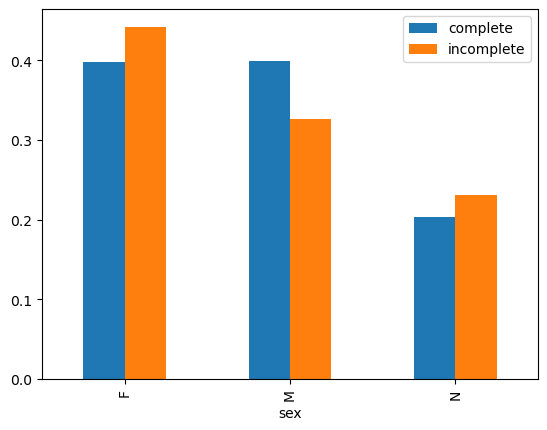

In [42]:
sg = (students.groupby('sex').count()['uuid']/len(students)).rename('complete')
ng = (null_course_taken.groupby('sex').count()['uuid']/len(null_course_taken)).rename('incomplete')
df = pd.concat([sg, ng], axis=1)
df.plot.bar()

<Axes: xlabel='job_id'>

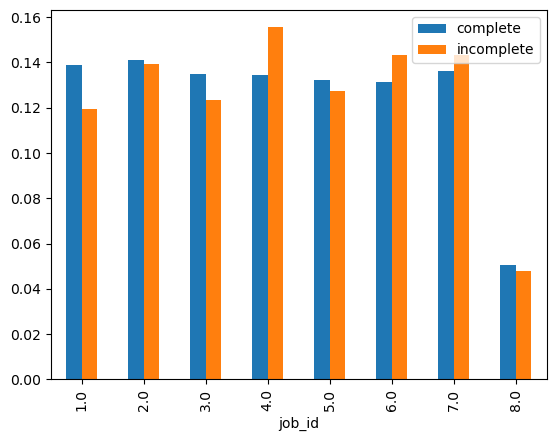

In [43]:
sg = (students.groupby('job_id').count()['uuid']/len(students)).rename('complete')
ng = (null_course_taken.groupby('job_id').count()['uuid']/len(null_course_taken)).rename('incomplete')
df = pd.concat([sg, ng], axis=1)
df.plot.bar()

<Axes: xlabel='age_group'>

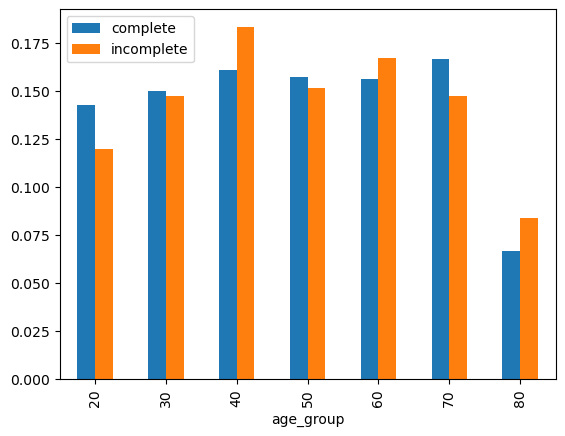

In [44]:
sg = (students.groupby('age_group').count()['uuid']/len(students)).rename('complete')
ng = (null_course_taken.groupby('age_group').count()['uuid']/len(null_course_taken)).rename('incomplete')
df = pd.concat([sg, ng], axis=1)
df.plot.bar()

In [45]:
null_data = pd.DataFrame()
null_data = pd.concat([null_data, null_course_taken])
students = students.dropna(subset=['num_course_taken'])

In [46]:
students.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4749 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    4749 non-null   int64         
 1   name                    4749 non-null   object        
 2   dob                     4749 non-null   datetime64[ns]
 3   sex                     4749 non-null   object        
 4   job_id                  4744 non-null   float64       
 5   num_course_taken        4749 non-null   float64       
 6   current_career_path_id  4298 non-null   float64       
 7   time_spent_hrs          4298 non-null   float64       
 8   age                     4749 non-null   int32         
 9   age_group               4749 non-null   int64         
 10  email                   4749 non-null   object        
 11  street                  4749 non-null   object        
 12  city                    4749 non-null   object       

#### job_id

In [47]:
null_job_id = students[students[['job_id']].isnull().any(axis=1)]
null_job_id.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code
162,163,Glen Riley,2002-08-22,M,NaN,8.0,3.0,5.70,23,20,glen_riley4484@hmail.com,P.O. Box 37267,Cornlea village,Tennessee,19192
757,758,Mercedez Vorberg,2002-03-25,F,NaN,15.0,4.0,4.14,23,20,mercedez6297@woohoo.com,284 Cedar Seventh,Virden village,Washington,60489
854,855,Kurt Ho,2002-05-29,M,NaN,0.0,8.0,23.72,23,20,ho6107@inlook.com,P.O. Box 27254,Olin,New Hampshire,60067
1029,1030,Penny Gaines,2002-03-01,N,NaN,15.0,4.0,16.25,23,20,gaines2897@hmail.com,138 Misty Vale,Stockton borough,West Virginia,53630
1542,1543,Frederick Reilly,2002-11-13,M,NaN,7.0,9.0,21.32,23,20,frederick_reilly6971@woohoo.com,P.O. Box 40769,Quakervillage,Maryland,96218


In [48]:
null_data = pd.concat([null_data, null_job_id])
students = students.dropna(subset=['job_id'])

In [49]:
students.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4744 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    4744 non-null   int64         
 1   name                    4744 non-null   object        
 2   dob                     4744 non-null   datetime64[ns]
 3   sex                     4744 non-null   object        
 4   job_id                  4744 non-null   float64       
 5   num_course_taken        4744 non-null   float64       
 6   current_career_path_id  4293 non-null   float64       
 7   time_spent_hrs          4293 non-null   float64       
 8   age                     4744 non-null   int32         
 9   age_group               4744 non-null   int64         
 10  email                   4744 non-null   object        
 11  street                  4744 non-null   object        
 12  city                    4744 non-null   object       

#### current_career_path_id

In [50]:
null_path_id = students[students[['current_career_path_id']].isnull().any(axis=1)]
null_path_id.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code
15,16,Norene Dalton,1976-04-30,F,6.0,0.0,NaN,NaN,49,40,norene_dalton9509@hmail.com,130 Wishing Essex,Branch,Ohio,13616
19,20,Sofia van Steenbergen,1990-02-21,N,7.0,13.0,NaN,NaN,35,30,vansteenbergen8482@inlook.com,634 Clear Barn Dell,Beaman,Georgia,33288
30,31,Christoper Warner,1989-12-28,M,2.0,5.0,NaN,NaN,36,30,warner5906@coldmail.com,556 Stony Highlands,Drain,Illinois,01973
49,50,Antony Horne,1996-05-29,M,3.0,2.0,NaN,NaN,29,20,antony577@coldmail.com,P.O. Box 78685,Lenox,Texas,15516
54,55,Omar Bunk,1955-11-08,M,3.0,14.0,NaN,NaN,70,70,omar1245@coldmail.com,445 Dale Hollow,Vermont village,South Carolina,28329


In [51]:
null_path_id.info()

<class 'pandas.core.frame.DataFrame'>
Index: 451 entries, 15 to 4974
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    451 non-null    int64         
 1   name                    451 non-null    object        
 2   dob                     451 non-null    datetime64[ns]
 3   sex                     451 non-null    object        
 4   job_id                  451 non-null    float64       
 5   num_course_taken        451 non-null    float64       
 6   current_career_path_id  0 non-null      float64       
 7   time_spent_hrs          0 non-null      float64       
 8   age                     451 non-null    int32         
 9   age_group               451 non-null    int64         
 10  email                   451 non-null    object        
 11  street                  451 non-null    object        
 12  city                    451 non-null    object       

In [52]:
students['current_career_path_id'].unique()

array([ 1.,  8.,  9.,  3.,  6., 10.,  5., nan,  4.,  7.,  2.])

In [53]:
students['current_career_path_id'] = np.where(
    students['current_career_path_id'].isnull(), 0, students['current_career_path_id']
)
students['time_spent_hrs'] = np.where(students['time_spent_hrs'].isnull(), 0, students['time_spent_hrs'])

In [54]:
students.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4744 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    4744 non-null   int64         
 1   name                    4744 non-null   object        
 2   dob                     4744 non-null   datetime64[ns]
 3   sex                     4744 non-null   object        
 4   job_id                  4744 non-null   float64       
 5   num_course_taken        4744 non-null   float64       
 6   current_career_path_id  4744 non-null   float64       
 7   time_spent_hrs          4744 non-null   float64       
 8   age                     4744 non-null   int32         
 9   age_group               4744 non-null   int64         
 10  email                   4744 non-null   object        
 11  street                  4744 non-null   object        
 12  city                    4744 non-null   object       

## __Career_paths Table__

In [55]:
display(career_paths)

,career_path_id,career_path_name,hours_to_complete
0,1,data scientist,20
1,2,data engineer,20
2,3,data analyst,12
3,4,software engineering,25
4,5,backend engineer,18
5,6,frontend engineer,20
6,7,iOS developer,27
7,8,android developer,27
8,9,machine learning engineer,35
9,10,ux/ui designer,15


In [56]:
career_paths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   career_path_id     10 non-null     int64 
 1   career_path_name   10 non-null     object
 2   hours_to_complete  10 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 372.0+ bytes


In [57]:
#add new career path id to account for students not taking a career path
not_applicable = {'career_path_id': 0, 'career_path_name': 'not_applicable', 'hours_to_complete': 0}

career_paths.loc[len(career_paths)] = not_applicable

In [58]:
display(career_paths)

,career_path_id,career_path_name,hours_to_complete
0,1,data scientist,20
1,2,data engineer,20
2,3,data analyst,12
3,4,software engineering,25
4,5,backend engineer,18
5,6,frontend engineer,20
6,7,iOS developer,27
7,8,android developer,27
8,9,machine learning engineer,35
9,10,ux/ui designer,15


## __Student_jobs Table__

In [59]:
display(student_jobs)

,job_id,job_category,avg_salary
0,1,analytics,86000
1,2,engineer,101000
2,3,software developer,110000
3,4,creative,66000
4,5,financial services,135000
5,6,education,61000
6,7,HR,80000
7,8,student,10000
8,9,healthcare,120000
9,0,other,80000


In [60]:
student_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   job_id        13 non-null     int64 
 1   job_category  13 non-null     object
 2   avg_salary    13 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 444.0+ bytes


In [61]:
student_jobs.drop_duplicates(inplace=True)
display(student_jobs)

,job_id,job_category,avg_salary
0,1,analytics,86000
1,2,engineer,101000
2,3,software developer,110000
3,4,creative,66000
4,5,financial services,135000
5,6,education,61000
6,7,HR,80000
7,8,student,10000
8,9,healthcare,120000
9,0,other,80000


# __Join Tables__

In [62]:
final_df = students.merge(career_paths, left_on='current_career_path_id', right_on='career_path_id', how='left')

In [63]:
final_df = final_df.merge(student_jobs, on='job_id', how='left')

In [64]:
final_df.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code,career_path_id,career_path_name,hours_to_complete,job_category,avg_salary
0,1,Annabelle Avery,1943-07-03,F,7.0,6.0,1.0,4.99,82,80,annabelle_avery9376@woohoo.com,303 N Timber Key,Irondale,Wisconsin,84736,1,data scientist,20,HR,80000
1,2,Micah Rubio,1991-02-07,M,7.0,5.0,8.0,4.40,34,30,rubio6772@hmail.com,767 Crescent Fair,Shoals,Indiana,37439,8,android developer,27,HR,80000
2,3,Hosea Dale,1989-12-07,M,7.0,8.0,8.0,6.74,36,30,hosea_dale8084@coldmail.com,P.O. Box 41269,St. Bonaventure,Virginia,83637,8,android developer,27,HR,80000
3,4,Mariann Kirk,1988-07-31,F,6.0,7.0,9.0,12.31,37,30,kirk4005@hmail.com,517 SE Wintergreen Isle,Lane,Arkansas,82242,9,machine learning engineer,35,education,61000
4,5,Lucio Alexander,1963-08-31,M,7.0,14.0,3.0,5.64,62,60,alexander9810@hmail.com,18 Cinder Cliff,Doyles borough,Rhode Island,73737,3,data analyst,12,HR,80000


In [65]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4744 entries, 0 to 4743
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    4744 non-null   int64         
 1   name                    4744 non-null   object        
 2   dob                     4744 non-null   datetime64[ns]
 3   sex                     4744 non-null   object        
 4   job_id                  4744 non-null   float64       
 5   num_course_taken        4744 non-null   float64       
 6   current_career_path_id  4744 non-null   float64       
 7   time_spent_hrs          4744 non-null   float64       
 8   age                     4744 non-null   int32         
 9   age_group               4744 non-null   int64         
 10  email                   4744 non-null   object        
 11  street                  4744 non-null   object        
 12  city                    4744 non-null   object  

# __Upsert Cleaned + Missing Data Tables To New DB__

In [67]:
con_out = sqlite3.connect(str(CLEANSED_DB_PATH))

In [68]:
final_df.to_sql('cademycode_aggregated', con_out, if_exists='replace', index=False)

4744

### sanity checks

In [69]:
db_df = pd.read_sql_query("SELECT * FROM cademycode_aggregated", con_out)

In [70]:
db_df.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code,career_path_id,career_path_name,hours_to_complete,job_category,avg_salary
0,1,Annabelle Avery,1943-07-03 00:00:00,F,7.0,6.0,1.0,4.99,82,80,annabelle_avery9376@woohoo.com,303 N Timber Key,Irondale,Wisconsin,84736,1,data scientist,20,HR,80000
1,2,Micah Rubio,1991-02-07 00:00:00,M,7.0,5.0,8.0,4.40,34,30,rubio6772@hmail.com,767 Crescent Fair,Shoals,Indiana,37439,8,android developer,27,HR,80000
2,3,Hosea Dale,1989-12-07 00:00:00,M,7.0,8.0,8.0,6.74,36,30,hosea_dale8084@coldmail.com,P.O. Box 41269,St. Bonaventure,Virginia,83637,8,android developer,27,HR,80000
3,4,Mariann Kirk,1988-07-31 00:00:00,F,6.0,7.0,9.0,12.31,37,30,kirk4005@hmail.com,517 SE Wintergreen Isle,Lane,Arkansas,82242,9,machine learning engineer,35,education,61000
4,5,Lucio Alexander,1963-08-31 00:00:00,M,7.0,14.0,3.0,5.64,62,60,alexander9810@hmail.com,18 Cinder Cliff,Doyles borough,Rhode Island,73737,3,data analyst,12,HR,80000


In [71]:
db_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4744 entries, 0 to 4743
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   float64
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4744 non-null   float64
 7   time_spent_hrs          4744 non-null   float64
 8   age                     4744 non-null   int64  
 9   age_group               4744 non-null   int64  
 10  email                   4744 non-null   object 
 11  street                  4744 non-null   object 
 12  city                    4744 non-null   object 
 13  state                   4744 non-null   object 
 14  zip_code                4744 non-null   

In [72]:
null_data.to_sql('incomplete_data', con_out, if_exists='replace', index=False)

256

In [73]:
null_df = pd.read_sql_query("SELECT * FROM incomplete_data", con_out)

In [74]:
null_df.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code
0,26,Doug Browning,1970-06-08 00:00:00,M,7.0,NaN,5.0,1.92,55,50,doug7761@inlook.com,P.O. Box 15845,Devine,Florida,23097
1,27,Damon Schrauwen,1953-10-31 00:00:00,M,4.0,NaN,10.0,3.73,72,70,damon9864@woohoo.com,P.O. Box 84659,Maben,Georgia,66137
2,52,Alisa Neil,1977-05-28 00:00:00,F,5.0,NaN,8.0,22.86,48,40,alisa9616@inlook.com,16 View Annex,Mosses,North Dakota,25748
3,71,Chauncey Hooper,1962-04-07 00:00:00,M,3.0,NaN,3.0,3.97,63,60,chauncey6352@woohoo.com,955 Dewy Flat,Slaughterville,South Carolina,22167
4,81,Ellyn van Heest,1984-06-28 00:00:00,F,3.0,NaN,10.0,12.39,41,40,ellyn_vanheest8375@hmail.com,872 Cider Glade,Chicken,Delaware,42689


In [75]:
con_out.close()

# __Create CSV File__

In [76]:
db_df.to_csv(CLEANSED_CSV_PATH, index=False)
print("Cleansed database and CSV written succfully")

Cleansed database and CSV written succfully
